In [4]:
# Connecting Google Colab to Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD


In [6]:
import os
import random

# Directory where the image files are stored
directory_path = '/content/gdrive/MyDrive/Augmented Data'

# Distribution of images per label
total_images = {'Normal': 2446, 'Malignant': 2309, 'Benign': 2532}

# Ratios for splitting the data
split_ratios = {
    'Training': 0.60,
    'Validation': 0.20,
    'Testing': 0.20
}

# Function to calculate split counts
def calculate_split_counts():
    split_counts = {split: {} for split in split_ratios}
    for label, count in total_images.items():
        for split, ratio in split_ratios.items():
            split_counts[split][label] = round(count * ratio)
    return split_counts

split_counts = calculate_split_counts()

# Load filenames and extract labels
filenames = os.listdir(directory_path)
labels = [f.split('_')[1] for f in filenames]

# Combine filenames and labels into a single list of tuples
data = list(zip(filenames, labels))

# Separate data by labels
data_by_label = {}
for file, label in data:
    if label not in data_by_label:
        data_by_label[label] = []
    data_by_label[label].append((file, label))

# Shuffle and split data
def shuffle_and_split(data_by_label, split_counts):
    train, val, test = [], [], []
    for label, files in data_by_label.items():
        random.shuffle(files)
        train_end = split_counts['Training'][label]
        val_end = train_end + split_counts['Validation'][label]
        train.extend(files[:train_end])
        val.extend(files[train_end:val_end])
        test.extend(files[val_end:])
    return train, val, test

train, val, test = shuffle_and_split(data_by_label, split_counts)

# Function to print counts per label in each set
def print_counts(data_split, name):
    count = {}
    for _, label in data_split:
        if label not in count:
            count[label] = 0
        count[label] += 1
    print(f"Counts for {name}: {count}")

# Print the counts for each set
print_counts(train, "Training")
print_counts(val, "Validation")
print_counts(test, "Testing")


Counts for Training: {'Normal': 1468, 'Benign': 1519, 'Malignant': 1385}
Counts for Validation: {'Normal': 489, 'Benign': 506, 'Malignant': 462}
Counts for Testing: {'Normal': 489, 'Benign': 507, 'Malignant': 462}


In [7]:
import tensorflow as tf

def load_and_preprocess_image(path, label):
    # Load the image file
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [64, 64])  # Resize the image to 64x64
    image /= 255.0  # Normalize image pixels to [0, 1]

    # Encode label (Assuming 'Malignant' is 1 and 'Benign' is 0)
    label = 1 if label == 'Malignant' else 0
    return image, label


def prepare_dataset(data, batch_size=32):
    # Paths and labels
    paths = [os.path.join(directory_path, fname) for fname, _ in data]
    labels = [label for _, label in data]
    # Create a dataset from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    # Map the loading function
    dataset = dataset.map(load_and_preprocess_image)
    # Shuffle, batch, and prefetch
    dataset = dataset.shuffle(buffer_size=len(paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Convert train, validation, and test lists to datasets
train_dataset = prepare_dataset(train)
val_dataset = prepare_dataset(val)
test_dataset = prepare_dataset(test)


In [6]:
def create_model():
    model = Sequential([
        Flatten(input_shape=(64, 64, 3)),  # Flatten the input images to a vector
        Dense(512, activation='relu'),     # First dense layer with 512 neurons
        Dense(256, activation='relu'),     # Second dense layer with 256 neurons
        Dense(128, activation='relu'),     # Third dense layer with 128 neurons
        Dense(64, activation='relu'),      # Fourth dense layer with 64 neurons
        Dense(1, activation='sigmoid')     # Output layer with sigmoid activation for binary classification
    ])
    return model


In [7]:
model = create_model()
model.compile(optimizer=SGD(learning_rate=0.0001),  # Stochastic Gradient Descent optimizer with a learning rate of 0.01
              loss='binary_crossentropy',         # Loss function for binary classification
              metrics=['accuracy'])               # Metric to monitor is accuracy


In [8]:
history = model.fit(train_dataset,          # Training dataset
                    epochs=20,              # Total number of epochs to train
                    validation_data=val_dataset)  # Validation dataset for monitoring validation loss and accuracy


Epoch 1/20
137/137 [==============================] - 305s 113ms/step - loss: 0.6803 - accuracy: 0.5652 - val_loss: 0.6437 - val_accuracy: 0.6754
Epoch 2/20
137/137 [==============================] - 25s 74ms/step - loss: 0.6305 - accuracy: 0.6821 - val_loss: 0.6284 - val_accuracy: 0.6829
Epoch 3/20
137/137 [==============================] - 26s 88ms/step - loss: 0.6208 - accuracy: 0.6828 - val_loss: 0.6235 - val_accuracy: 0.6829
Epoch 4/20
137/137 [==============================] - 24s 76ms/step - loss: 0.6162 - accuracy: 0.6828 - val_loss: 0.6201 - val_accuracy: 0.6829
Epoch 5/20
137/137 [==============================] - 30s 109ms/step - loss: 0.6126 - accuracy: 0.6828 - val_loss: 0.6171 - val_accuracy: 0.6829
Epoch 6/20
137/137 [==============================] - 28s 107ms/step - loss: 0.6094 - accuracy: 0.6828 - val_loss: 0.6143 - val_accuracy: 0.6829
Epoch 7/20
137/137 [==============================] - 24s 76ms/step - loss: 0.6063 - accuracy: 0.6828 - val_loss: 0.6114 - val_accur

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)


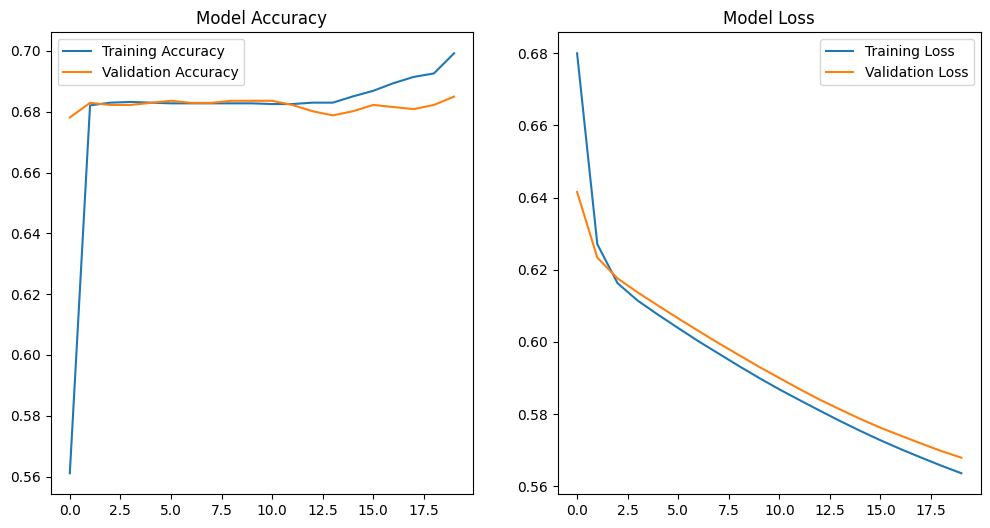

In [15]:
import matplotlib.pyplot as plt
# Plot training and validation history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

In [9]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


46/46 [==============================] - 5s 13ms/step - loss: 0.5855 - accuracy: 0.6845
Test Loss: 0.5854792594909668
Test Accuracy: 0.6844993233680725


In [10]:
# Making predictions on the test dataset
predictions = model.predict(test_dataset)

# If your model ends with a sigmoid activation (binary classification), you might want to apply a threshold
# Here we assume a threshold of 0.5 for binary classification
predicted_classes = (predictions > 0.5).astype(int)

# Print the first few predictions
print("Predictions:\n", predicted_classes[:10])


46/46 [==============================] - 6s 13ms/step
Predictions:
 [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Assume you can extract the true labels from the test_dataset
# You may need to adjust this depending on how your data is structured
true_labels = []
for images, labels in test_dataset.unbatch().take(len(predictions)):
    true_labels.append(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)


# Generate a classification report
cr = classification_report(true_labels, predicted_classes, target_names=['Class 0', 'Class 1'])
print("Classification Report:\n", cr)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.68      0.98      0.81       996
     Class 1       0.36      0.02      0.04       462

    accuracy                           0.68      1458
   macro avg       0.52      0.50      0.42      1458
weighted avg       0.58      0.68      0.56      1458



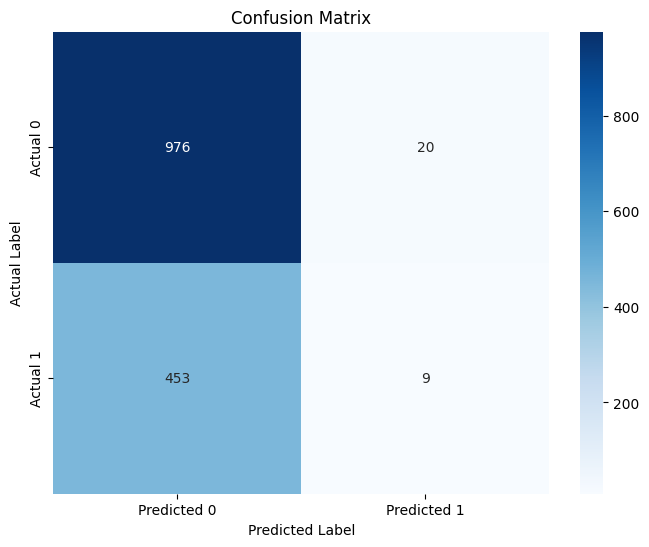

In [15]:
import seaborn as sns  # For a nicer confusion matrix visualization
# Plotting using matplotlib and seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Assuming 'history' is the object returned by model.fit()
test_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(test_loss) + 1)


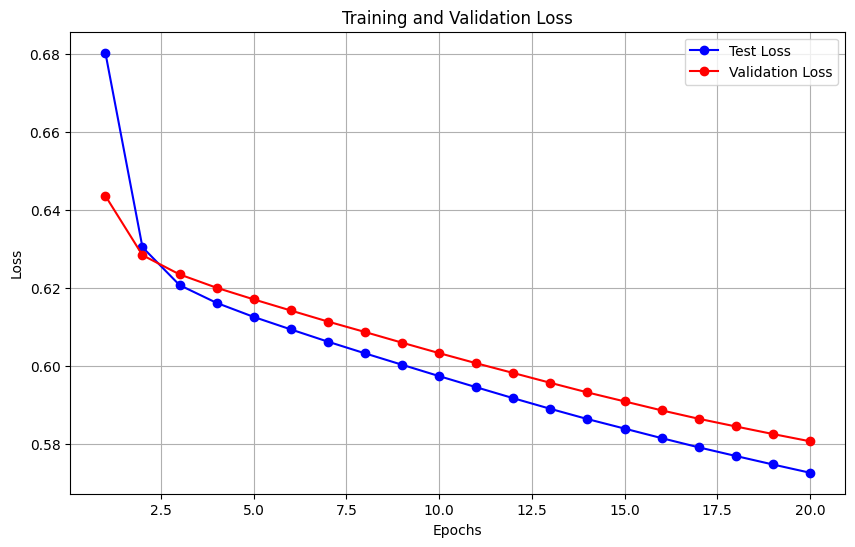

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(epochs, test_loss, 'bo-', label='Test Loss')  # 'bo-' gives blue color with circle markers and a solid line
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # 'ro-' gives red color with circle markers and a solid line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 28.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [9]:
import numpy as np

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch().take(-1):  # Take all data from the dataset
        images.append(image.numpy())
        labels.append(label)
    return np.array(images), np.array(labels)

# Convert datasets to numpy arrays
X_train, y_train = dataset_to_numpy(train_dataset)
X_val, y_val = dataset_to_numpy(val_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)


In [29]:
from tensorflow.keras.layers import Input

def create_model():
    model = Sequential([
        Input(shape=(64, 64, 3)),  # Specify input shape explicitly at the start
        Flatten(),  # Flatten the input images to a vector
        Dense(512, activation='relu'),  # First dense layer with 512 neurons
        Dense(256, activation='relu'),  # Second dense layer with 256 neurons
        Dense(128, activation='relu'),  # Third dense layer with 128 neurons
        Dense(64, activation='relu'),   # Fourth dense layer with 64 neurons
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [30]:
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(model=create_model, epochs=10, batch_size=32)

param_grid = {
    'optimizer': ['adam', 'sgd'],
    'batch_size': [32, 64],  # Example additional parameter
}

# Ensuring error_score is set to 'raise' to identify issues directly
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=1, cv=3, n_iter=2, error_score='raise')
random_search_result = random_search.fit(X_train, y_train)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.6156 - loss: 0.7816
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.7010 - loss: 0.5788
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 92ms/step - accuracy: 0.7678 - loss: 0.5190
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.7833 - loss: 0.4911
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 98ms/step - accuracy: 0.8122 - loss: 0.4541
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7960 - loss: 0.4722
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.8137 - loss: 0.4401
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8399 - loss: 0.3957
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.8332 - loss: 0.4044
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8166 - loss: 0.4137
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.6470 - loss: 0.8476
Epoch 2/1

In [31]:
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


Best: 0.794600 using {'optimizer': 'adam', 'batch_size': 32}


In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions
test_predictions = random_search_result.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Test Accuracy: 0.7928669410150891
Test Precision: 0.761437908496732
Test Recall: 0.5043290043290043
Test F1 Score: 0.6067708333333334


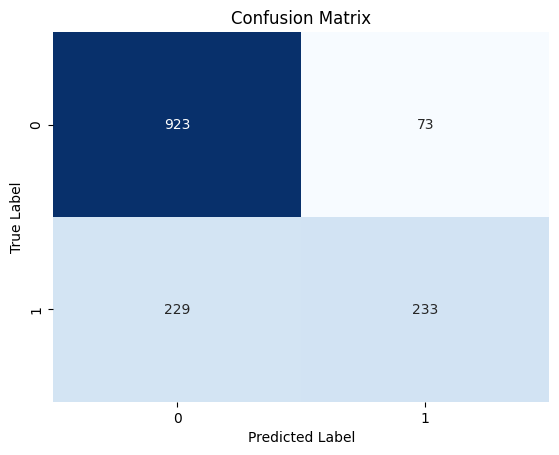

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'cm' is your confusion matrix and 'test_predictions' are already computed
cm = confusion_matrix(y_test, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, random_search_result.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, test_predictions)

print("ROC AUC Score:", auc)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
ROC AUC Score: 0.7155179158191206


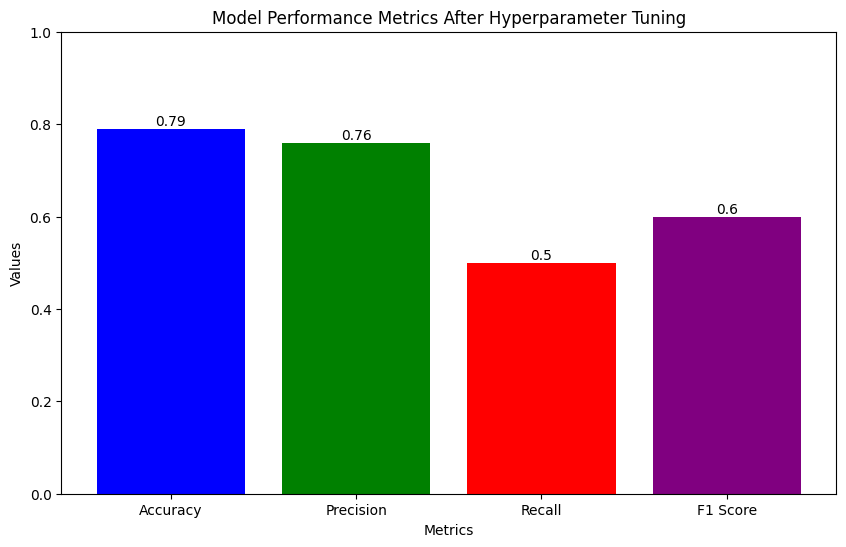

In [42]:
import matplotlib.pyplot as plt

# Metrics values
metrics = {
    "Accuracy": 0.79,
    "Precision": 0.76,
    "Recall": 0.50,
    "F1 Score": 0.60
}

# Creating the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])

# Adding title and labels
plt.title('Model Performance Metrics After Hyperparameter Tuning')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.ylim(0, 1)  # Setting the limit for y-axis

# Adding the numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Show the plot
plt.show()
